In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [15]:
fpath = "F:\\pp1_data_processing\\2023-05-30_16-01-57 adc camera recording desk 200MHz.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-30_16-05-04 adc blank screen boot up.csv"
# fpath = "F:\\pp1_data_processing\\2023-05-30_16-08-50 adc showing desk from no input to camera plugin.csv"
df = pd.read_csv(fpath)
df['datetime'] = pd.to_datetime(df['Time[s]'], unit='s') # add datetime column

In [16]:
df

,Time[s],ADC0,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,!VID_CONV,ADC_VRT*,!ADC_VRB_REF0,ADC_VRB_REF1,VID_BLK,MCLK,datetime
0,-0.046521,0,0,0,0,0,0,0,0,1,0,1,1,1,1969-12-31 23:59:59.953478820
1,-0.046521,0,0,0,0,0,0,0,1,1,0,1,1,1,1969-12-31 23:59:59.953478855
2,-0.046521,0,0,0,0,0,0,0,1,1,0,1,1,0,1969-12-31 23:59:59.953478860
3,-0.046521,0,0,0,0,0,0,0,0,1,0,1,1,0,1969-12-31 23:59:59.953478890
4,-0.046521,0,0,0,0,0,0,0,1,1,0,1,1,0,1969-12-31 23:59:59.953478925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41942955,0.879480,1,0,0,1,1,1,0,0,1,1,1,0,1,1970-01-01 00:00:00.879479895
41942956,0.879480,1,0,0,1,1,1,0,1,1,1,1,0,1,1970-01-01 00:00:00.879479915
41942957,0.879480,1,0,0,1,1,1,0,0,1,1,1,0,1,1970-01-01 00:00:00.879479945
41942958,0.879480,1,0,1,1,1,1,0,0,1,1,1,0,1,1970-01-01 00:00:00.879479960


# MCLK FREQ

In [91]:
# find positions of all peak edges of the MCLK signal
_,mclk_pk_prop = signal.find_peaks(df[' MCLK'], plateau_size=[1]) # minimum peak width of 1 sample
# find time differences between each of the rising edges of the peaks
timediff = df['datetime'].iloc[mclk_pk_prop['left_edges']].diff()
# store frequencies into df
df['MCLKFREQ'] = pd.NA
df.loc[mclk_pk_prop['left_edges'], 'MCLKFREQ'] = 1/(timediff.to_numpy('float64') * 1e-9)

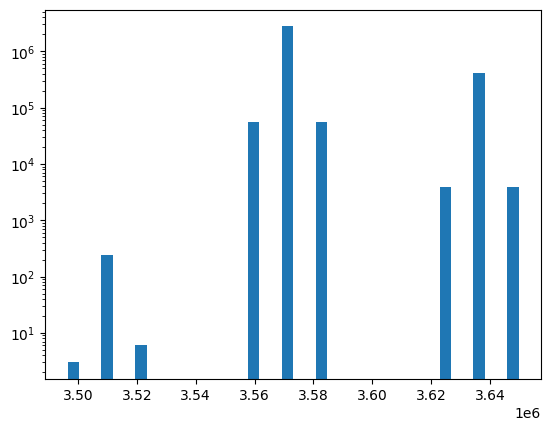

In [60]:
plt.hist(df['MCLKFREQ'].iloc[10:].dropna().astype('float64'), bins=40)
plt.yscale('log')

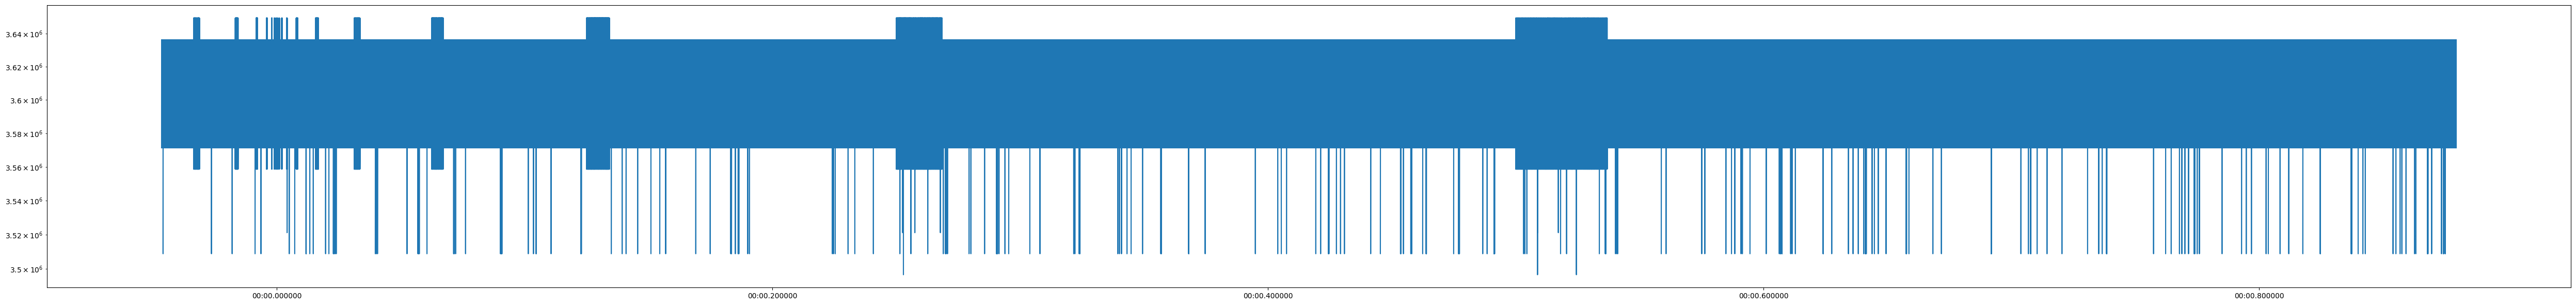

In [73]:
fig, ax = plt.subplots(figsize=(50, 6))
ax.plot(df.loc[mclk_pk_prop['left_edges'][1:],'datetime'], df.loc[mclk_pk_prop['left_edges'][1:], 'MCLKFREQ'])
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [92]:
# fill NAs with the last valid observed frequency
df['MCLKFREQ'] = df['MCLKFREQ'].fillna(method='ffill').fillna(method='bfill')

# Turning binary to decimal

In [81]:
# conversion occurs on the negative edge of the CLK
# we are working with 7 bits
adcdf = df.loc[df[' !VID_CONV'].diff() == -1].copy()
adcdf.reset_index(inplace=True, drop=True)
adcdf.drop(columns=' !VID_CONV', inplace=True)
# get bits
bits_arr = adcdf[[' ADC0', ' ADC1', ' ADC2', ' ADC3', ' ADC4', ' ADC5', ' ADC6']].to_numpy()
# convert to decimal
decimal_arr = np.sum(bits_arr * (2**np.arange(0,7)), axis=1)
# store to adcdf VALUE columns
adcdf['VALUE'] = decimal_arr
# drop bit columns from adcdf
adcdf.drop(columns=[' ADC0', ' ADC1', ' ADC2', ' ADC3', ' ADC4', ' ADC5', ' ADC6'], inplace=True)

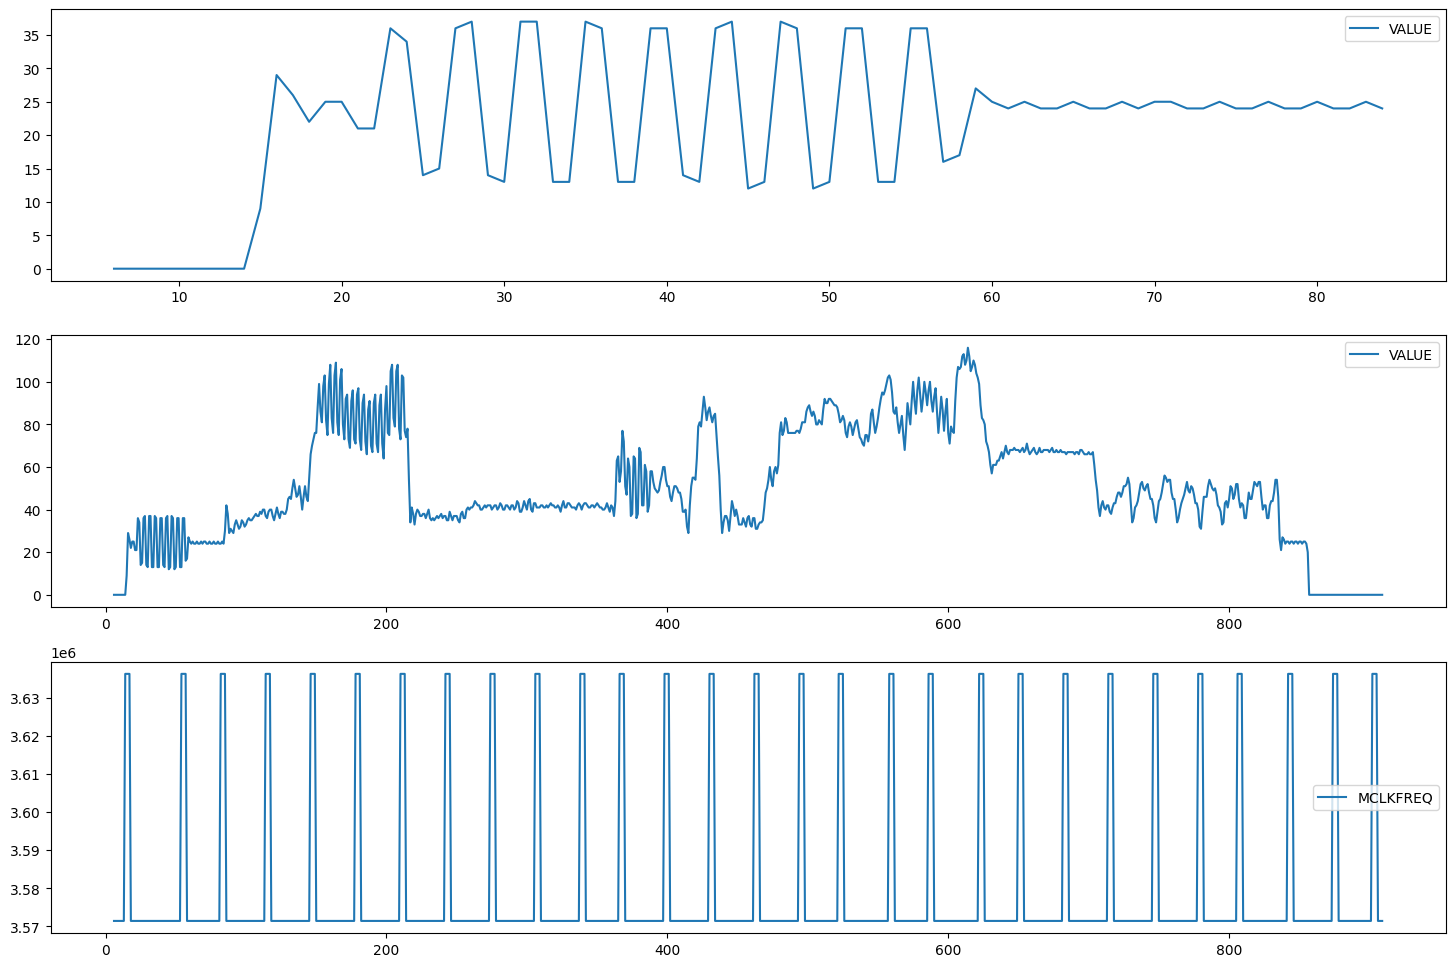

In [90]:
rows = 3
fig, axs = plt.subplots(nrows=rows,ncols=1)
fig.set_size_inches(18, rows*4)
adcdf.iloc[6:85].plot(y='VALUE', use_index=True, ax=axs[0])
adcdf.iloc[6:910].plot(y='VALUE', use_index=True, ax=axs[1])
adcdf.iloc[6:910].plot(y='MCLKFREQ', use_index=True, ax=axs[2])
plt.show()